In [1]:
import scanpy as sc
import squidpy as sq
import NaiveDE
import SpatialDE

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [2]:
adata = sq.datasets.visium_hne_adata()

In [5]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/mowp/mambaforge/envs/st/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mowp/mambaforge/envs/st/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


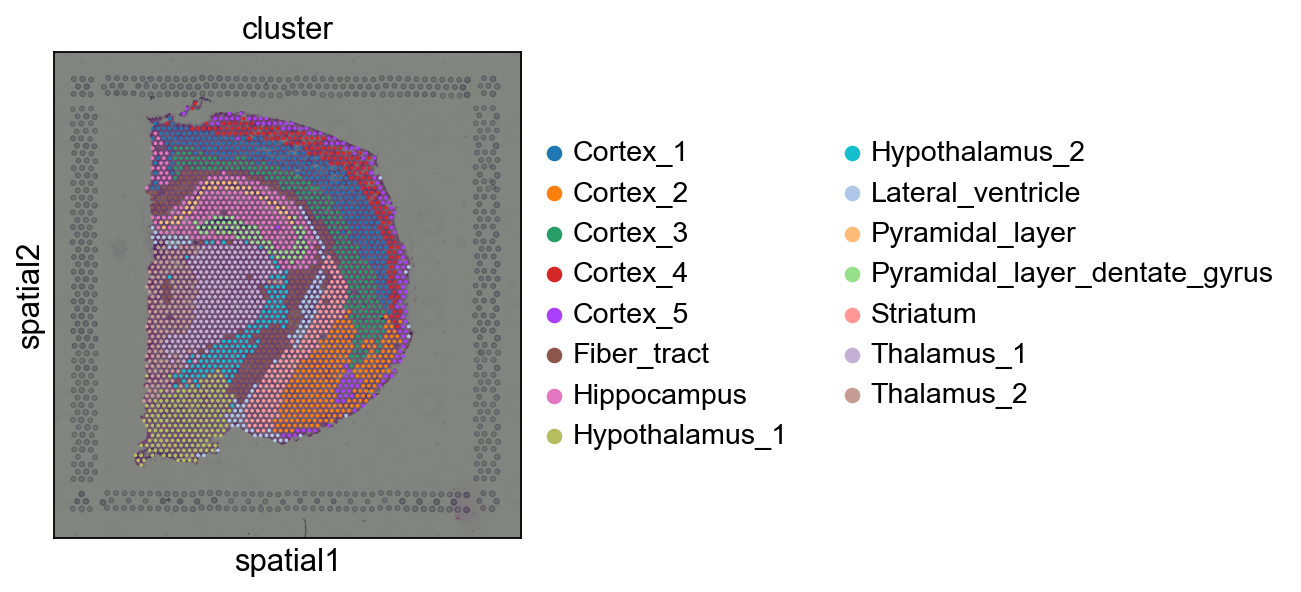

In [6]:
sq.pl.spatial_scatter(adata, color=['cluster'])

# Moran’s I score in Squidpy

One approach for the identification of spatially variable genes is the Moran’s I score, a measure of spatial autocorrelation (correlation of signal, such as gene expression, in observations close in space).

It is defined as: ${I = \frac{n}{W}\frac{{\mathop {\sum }\nolimits_{i = 1}^n \mathop {\sum }\nolimits_{j = 1}^n w_{i,j}z_iz_j}}{{\mathop {\sum }\nolimits_{i = 1}^n z_i^2}})}$ where


- $z_{i}$ is the deviation of the feature from the mean $\left( {x_i - \bar X} \right)$

- $w_{i,j}$ is the spatial weight between observations

- $n$ is the number of spatial units

- $W$ is the sum of all $w_{i,j}$

In [7]:
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)  # For the purpose of the example, we will compute it only for a few genes.

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `None` permutations using `1` core(s)
Adding `adata.uns['moranI']`
Finish (0:00:00)


In [20]:
adata.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
Nrgn,0.874753,0.000000,0.000131,0.000000
Mbp,0.868723,0.000000,0.000131,0.000000
Camk2n1,0.866542,0.000000,0.000131,0.000000
Slc17a7,0.861761,0.000000,0.000131,0.000000
Ttr,0.841986,0.000000,0.000131,0.000000
...,...,...,...,...
Slc9a8,-0.026960,0.010026,0.000131,0.017977
Pramef8,-0.028656,0.006687,0.000131,0.012356
Klf12,-0.028760,0.006518,0.000131,0.012061
Gart,-0.028857,0.006364,0.000131,0.011789


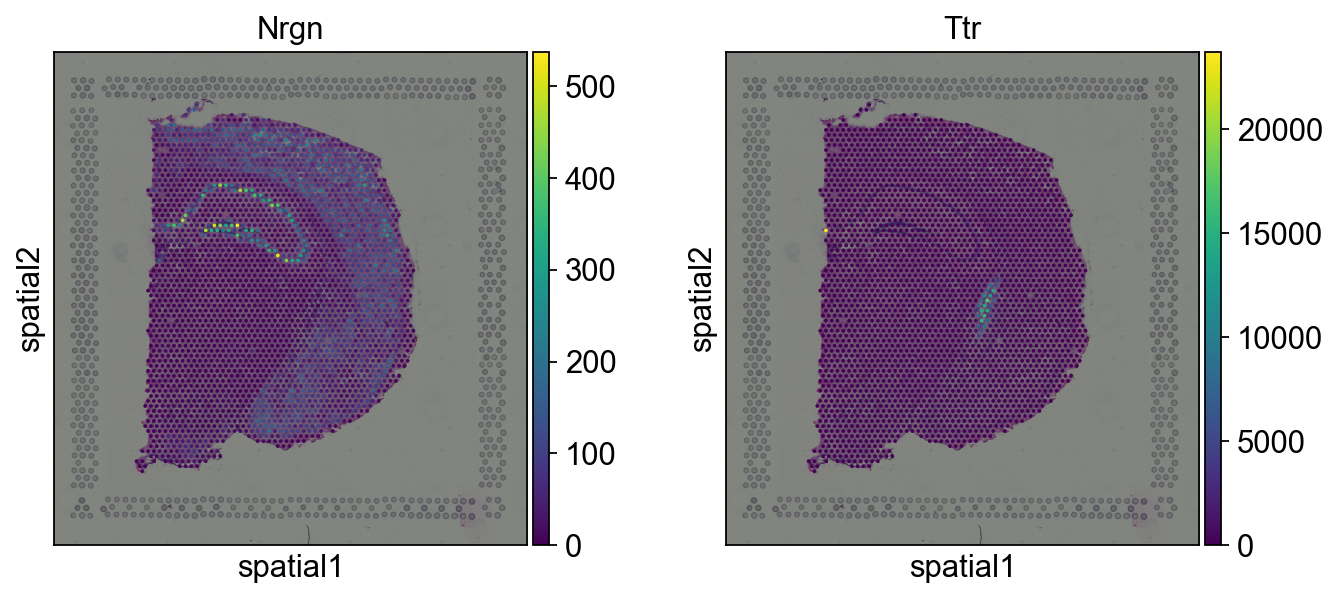

In [9]:
sq.pl.spatial_scatter(adata, color=["Nrgn", "Ttr"])

# SpatialDE

In [11]:
adata.var_names_make_unique()

In [12]:
counts = sc.get.obs_df(adata, keys=list(adata.var_names), use_raw=True)

In [22]:
counts

,Xkr4,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,Rb1cc1,...,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,Gm10931,AC149090.1,CAAA01118383.1,CAAA01147332.1
AAACAAGTATCTCCCA-1,0.0,0.0,1.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,...,42.0,5.0,350.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,...,39.0,5.0,268.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,...,38.0,1.0,484.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,...,40.0,3.0,322.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
AAACCGGGTAGGTACC-1,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,...,55.0,1.0,535.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,1.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,...,32.0,0.0,398.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
TTGTTTCACATCCAGG-1,0.0,1.0,1.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0,...,57.0,0.0,488.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,36.0,5.0,301.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0
TTGTTTCCATACAACT-1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,53.0,3.0,439.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0


In [13]:
total_counts = sc.get.obs_df(adata, keys=["total_counts"])

In [23]:
total_counts

,total_counts
AAACAAGTATCTCCCA-1,19340.0
AAACAATCTACTAGCA-1,13750.0
AAACACCAATAACTGC-1,32710.0
AAACAGAGCGACTCCT-1,15909.0
AAACCGGGTAGGTACC-1,31856.0
...,...
TTGTTGTGTGTCAAGA-1,34390.0
TTGTTTCACATCCAGG-1,44372.0
TTGTTTCATTAGTCTA-1,24432.0
TTGTTTCCATACAACT-1,27381.0


In [14]:
norm_expr = NaiveDE.stabilize(counts.T).T

/home/mowp/mambaforge/envs/st/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [15]:
resid_expr = NaiveDE.regress_out(total_counts, norm_expr.T, "np.log(total_counts)").T

In [16]:
results = SpatialDE.run(adata.obsm["spatial"], resid_expr)

Models: 100%|██████████| 10/10 [12:39<00:00, 75.90s/it]


In [17]:
results.head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
0,1.065401e-01,4,Mrpl15,68.5,8.383709e+00,-2836.151214,-8.553531,7.251816e+00,SE,2688,0.004038,3.928962e-01,0.011876,5703.888638,-2836.979675,0.828461,0.362718,0.462134
1,1.132153e-06,4,4732440D04Rik,68.5,8.830160e+05,1005.684526,-0.849110,8.478788e-07,SE,2688,0.043425,2.453029e+10,0.002018,-1979.782841,1005.684427,0.000099,0.992065,0.992308
2,2.556985e-01,4,Rrs1,68.5,2.910013e+00,-2372.430326,-5.025306,5.476694e+00,SE,2688,0.001739,5.062643e-02,0.004742,4776.446863,-2376.942600,4.512273,0.033652,0.056698
3,2.492298e-01,4,Cops5,68.5,3.011488e+00,-2579.842014,-11.139281,2.601672e+01,SE,2688,0.001748,5.234926e-02,0.004646,5191.270239,-2584.203102,4.361088,0.036769,0.061422
4,2.060557e-09,4,Cpa6,68.5,4.851652e+08,2817.673498,-0.768099,1.230862e-09,SE,2688,0.031812,5.424958e+15,0.001929,-5603.760785,2817.673405,0.000093,0.992305,0.992308


The resulting DataFrame contains the following important columns:

- g, the gene name

- l, a parameter indicating the genes distance scale a gene changes expression over

- pval, the p-value for spatial differential expression

- qval, the corrected p-value after correcting for multiple testing

In [18]:
top10 = results.sort_values("qval").head(10)[["g", "l", "qval"]]
top10

,g,l,qval
9038,Atp2a1,827.718319,0.0
6587,Cox4i1,443.950519,0.0
6588,Fbxo31,443.950519,0.0
6589,Jph3,443.950519,0.0
6590,Rpl13,443.950519,0.0
6591,Cpne7,443.950519,0.0
6592,Spata2l,443.950519,0.0
6593,Tcf25,443.950519,0.0
6594,Tubb3,443.950519,0.0
6595,Rhou,443.950519,0.0


We can now plot the top-three significant genes and inspect their spatial pattern. We additionally plot the clusters of the dataset to analyze whether the detected genes might be linked to specific clusters.

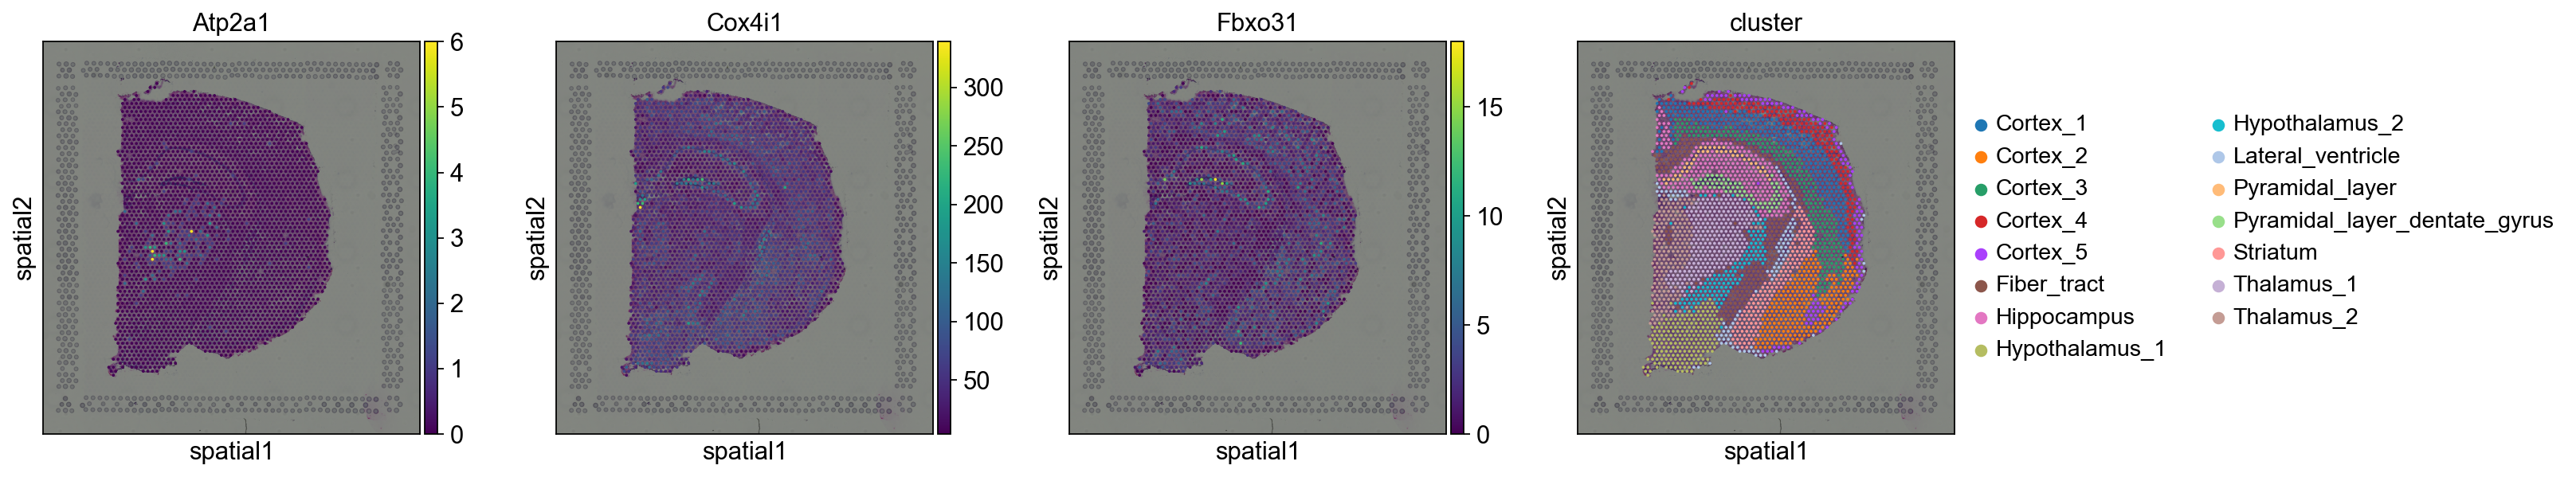

In [19]:
sq.pl.spatial_scatter(adata, color=list(top10["g"][:3]) + ["cluster"])

# Key takeaways

- Spatially variable genes (SVGs) are genes that show a significant spatial pattern

- Methods designed for this task vary in complexity and model assumptions

- We recommend using multiple methods to identify SVGs and assess the result by plotting the gene’s expression in space.

In [25]:
import session_info

session_info.show()